In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from glob import glob
from scipy.interpolate import interp1d, BSpline, splrep, bisplev, bisplrep

import mpl_style as mplt
import matplotlib
from dark_matter_limit_plotter import make_spline
import constants as const
from scipy.special import erf

plt.style.use(['mvstyle', 'one_piece', 'half_page'])

In [2]:
def mchiCgeom(Rstar, Mstar):
    """
    Geometric Cross section of the NS in natural units

    mdm in GeV
    R in km
    """

    vs = 20.0
    vd = float(np.sqrt((8.0 * 1000.0 / const.cspeed )**2 + 3.0 * const.kBeV * 1e5 / const.me))
    rhoDM = 798.0

    BR = 1.0  - 2.0 * const.GNewt * Mstar * const.Msol/ (Rstar * 1e3) / const.cspeed**2

    return np.pi * (Rstar * const.kmTOm * const.mTOinveV)**2 * (1.0 - BR) * (rhoDM / const.cmTOm**3 / const.mTOinveV**3) * erf(np.sqrt(3.0 * vs/2.0/vd)) / BR / (vs * const.kmTOm / const.cspeed) * 1e3


In [3]:
masses, Teffs, Tcores = np.loadtxt('WD_data/berg_thin_tempertures.txt', skiprows=2, unpack=True)

Tcore_interp = bisplrep(masses, np.log10(Teffs), np.log10(Tcores), s = 0.1)

def Tcore(mass, temp):
    
    ltemp = np.log10(temp)
    mass = np.array(mass)

    return 10**np.array([bisplev(mass[ii], ltemp[ii], Tcore_interp) for ii in range(len(mass))])


In [4]:
Teffs, Lums, Rstars, Mstars = np.loadtxt('WD_data/M4_data.dat', skiprows=1, unpack=True, usecols=(1, 2, 3, 4))
Lums = Lums * 1e28 * 1e-7 * 6.242e18*1e-6 # in MeV/s
Rstars = Rstars # in km

spot_colours = Teffs #Tcore(Mstars, Teffs)

In [5]:
crate_file_names = glob('capture_WD/*')
crate_files = [xx.lstrip('capture_WD/crate_') for xx in crate_file_names]
crate_files = [xx.lstrip('capture_WD/crate_') for xx in crate_files]
ms_dm = np.array([float(xx.rstrip('.dat')) for xx in crate_files])

ms_dm, crate_file_names = (list(t) for t in zip(*sorted(zip(ms_dm, crate_file_names))))

In [6]:
mass_2 = 1e4
mass_1 = 1.

crates_2 = np.array([])
for file in crate_file_names:
    _mass, Crate = np.loadtxt(file, skiprows=1, usecols=(0, 1), unpack=True)
    crates_2 = np.append(crates_2, Crate[np.argmin(np.abs(_mass - mass_2))])

crates_1 = np.array([])
for file in crate_file_names:
    _mass, Crate = np.loadtxt(file, skiprows=1, usecols=(0, 1), unpack=True)
    crates_1 = np.append(crates_1, Crate[np.argmin(np.abs(_mass - mass_1))])

In [7]:
def Lum_DM(mchi, Cdm, LamDM):

    return mchi * Cdm / LamDM**4

In [8]:
_masses, _rads = (list(t) for t in zip(*sorted(zip(Mstars, Rstars))))
mchiCgeom_int = mplt.make_spline(_masses[:-3], mchiCgeom(np.array(_rads)[:-3], np.array(_masses)[:-3])/const.inveVTOs, 0.0001, 3,  xscale='linear', yscale='log')

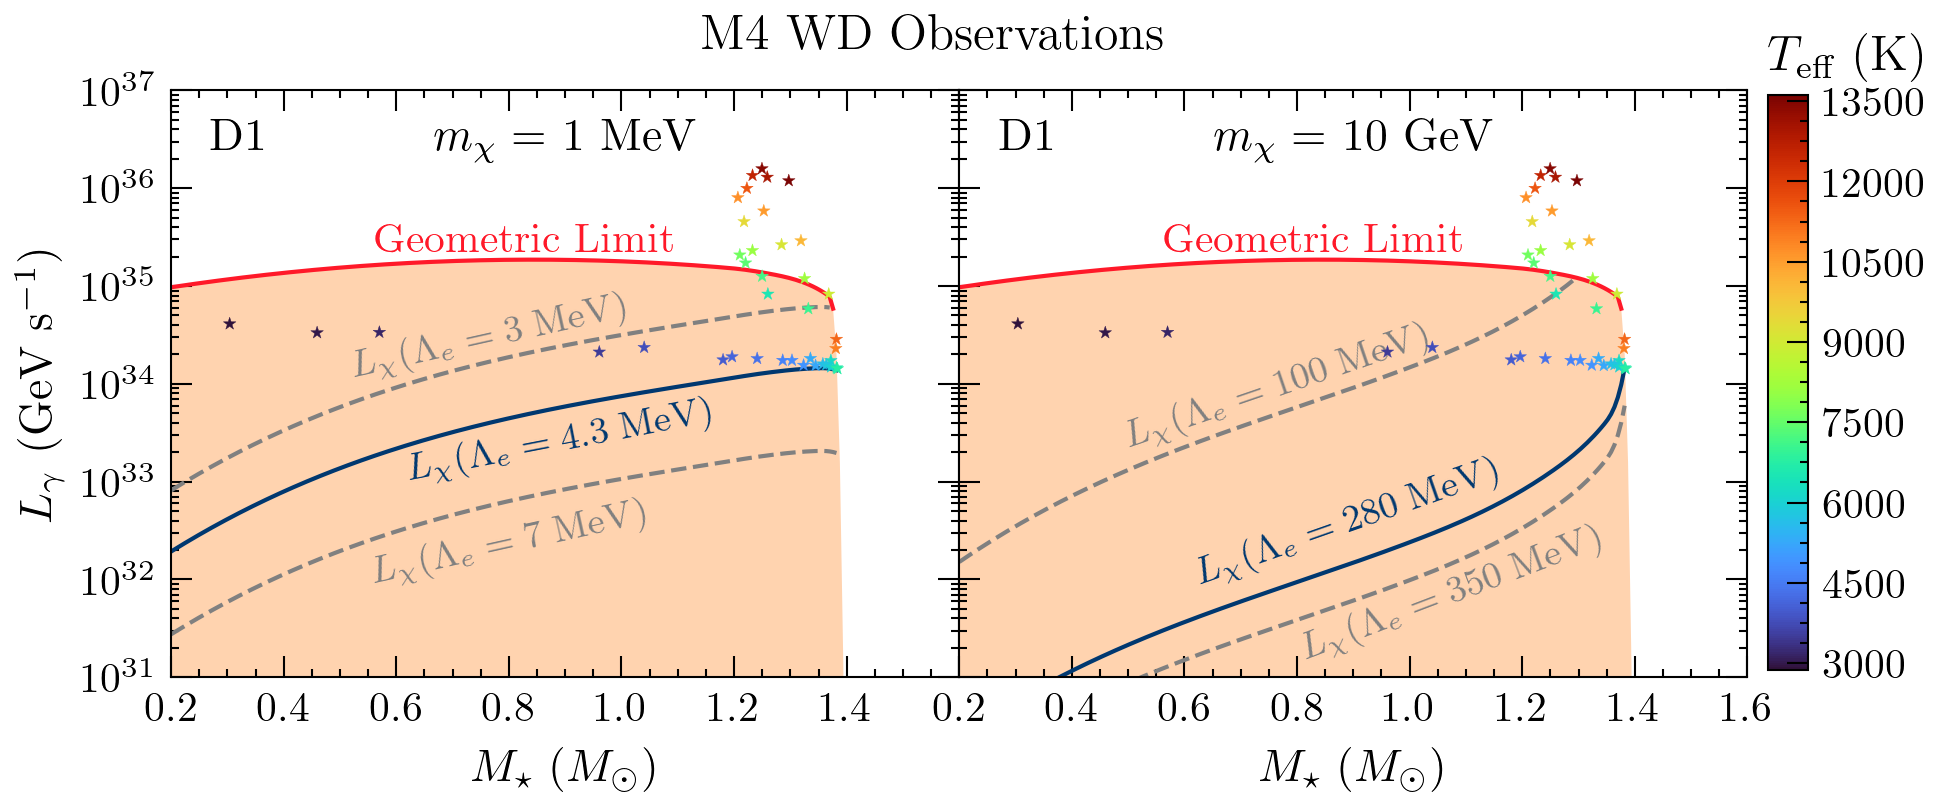

In [57]:
fig, ax = mplt.generate_subplots(2)
# fig, ax = plt.subplots(1, 3)
# fig, ax = plt.subplots()
WDs_scatter = ax[0].scatter(Mstars, Lums, c=spot_colours, cmap='turbo', marker='*', s = 10, lw = 0.1, zorder = 10)
WDs_scatter = ax[1].scatter(Mstars, Lums, c=spot_colours, cmap='turbo', marker='*', s = 10, lw = 0.1, zorder = 10)

plot_masses = np.linspace(0.2, 1.4, 200)
ax[0].plot(plot_masses[:-4], mchiCgeom_int(plot_masses[:-4]), zorder = 2, c = 'C00')

lum_1 = mplt.make_spline(ms_dm, Lum_DM(mass_1, crates_1, 4.3), 0.001, 3, xscale='linear')
lum_2 = mplt.make_spline(ms_dm, Lum_DM(mass_1, crates_1, 3.0), 0.001, 3, xscale='linear')
lum_3 = mplt.make_spline(ms_dm, Lum_DM(mass_1, crates_1, 7.), 0.001, 3, xscale='linear')

ax[0].plot(plot_masses, np.where(lum_1(plot_masses) <= mchiCgeom_int(plot_masses), lum_1(plot_masses), None), c = 'C07')
ax[0].plot(plot_masses, np.where(lum_2(plot_masses) <= mchiCgeom_int(plot_masses), lum_2(plot_masses), None), c = 'grey', ls = '--')
ax[0].plot(plot_masses, np.where(lum_3(plot_masses) <= mchiCgeom_int(plot_masses), lum_3(plot_masses), None), c = 'grey', ls = '--')


# ax[0].text(0.8, 1e33, 'ok')
ax[0].fill_between(plot_masses, 1e30, mchiCgeom_int(plot_masses), alpha = 0.4, color = 'C02', ec = 'none', zorder = -1)

ax[0].set_yscale('log')
ax[0].set_ylim(1e31, 1e37)
ax[0].set_xlim(0.2, 1.6)

mplt.label_line(ax[0], [plot_masses, np.where(lum_1(plot_masses) <= mchiCgeom_int(plot_masses), lum_1(plot_masses), None)], r'$L_\chi(\Lambda_e = 4.3\;\mathrm{MeV})$', 0.9, valign = 'center', xshift=-1, yshift=-8, size = 9, txt_col = 'C07')
mplt.label_line(ax[0], [plot_masses, np.where(lum_2(plot_masses) <= mchiCgeom_int(plot_masses), lum_2(plot_masses), None)], r'$L_\chi(\Lambda_e = 3\;\mathrm{MeV})$', 0.8, valign = 'center', xshift=-5, yshift=5, size = 9, txt_col = 'grey')
mplt.label_line(ax[0], [plot_masses, np.where(lum_3(plot_masses) <= mchiCgeom_int(plot_masses), lum_3(plot_masses), None)], r'$L_\chi(\Lambda_e = 7\;\mathrm{MeV})$', 0.8, valign = 'center', xshift=0, yshift=-10, size = 9, txt_col = 'grey')

plot_masses = np.linspace(0.2, 1.4, 200)
ax[1].plot(plot_masses[:-4], mchiCgeom_int(plot_masses[:-4]), zorder = 2, c = 'C00')

lum_1 = mplt.make_spline(ms_dm, Lum_DM(mass_2, crates_2, 2.8e2), 0.001, 3, xscale='linear')
lum_2 = mplt.make_spline(ms_dm, Lum_DM(mass_2, crates_2, 1e2), 0.001, 3, xscale='linear')
lum_3 = mplt.make_spline(ms_dm, Lum_DM(mass_2, crates_2, 3.5e2), 0.001, 3, xscale='linear')

ax[1].plot(plot_masses, np.where(lum_1(plot_masses) <= mchiCgeom_int(plot_masses), lum_1(plot_masses), None), c = 'C07')
ax[1].plot(plot_masses, np.where(lum_2(plot_masses) <= mchiCgeom_int(plot_masses), lum_2(plot_masses), None), c = 'grey', ls = '--')
ax[1].plot(plot_masses, np.where(lum_3(plot_masses) <= mchiCgeom_int(plot_masses), lum_3(plot_masses), None), c = 'grey', ls = '--')


# ax[1].text(0.8, 1e33, 'ok')
ax[1].fill_between(plot_masses, 1e30, mchiCgeom_int(plot_masses), alpha = 0.4, color = 'C02', ec = 'none', zorder = -1)

ax[1].set_yscale('log')
ax[1].set_ylim(1e31, 1e37)
ax[1].set_xlim(0.2, 1.6)

mplt.label_line(ax[1], [plot_masses, np.where(lum_1(plot_masses) <= mchiCgeom_int(plot_masses), lum_1(plot_masses), None)], r'$L_\chi(\Lambda_e = 280\;\mathrm{MeV})$', 0.9, valign = 'center', xshift=-1, yshift=10, size = 9, txt_col = 'C07')
mplt.label_line(ax[1], [plot_masses, np.where(lum_2(plot_masses) <= mchiCgeom_int(plot_masses), lum_2(plot_masses), None)], r'$L_\chi(\Lambda_e = 100\;\mathrm{MeV})$', 0.8, valign = 'center', xshift=-5, yshift=5, size = 9, txt_col = 'grey')
mplt.label_line(ax[1], [plot_masses, np.where(lum_3(plot_masses) <= mchiCgeom_int(plot_masses), lum_3(plot_masses), None)], r'$L_\chi(\Lambda_e = 350\;\mathrm{MeV})$', 1., halign = 'center', valign = 'center', xshift=10, yshift=-3, size = 9, txt_col = 'grey', rotn_adj=0)

locmajx = matplotlib.ticker.MaxNLocator(8)
ax[0].xaxis.set_major_locator(locmajx)

ax[0].set_ylabel(r'$L_\gamma$ (GeV s$^{-1}$)')
ax[0].set_xlabel(r'$M_\star\;(M_\odot)$')
ax[1].set_xlabel(r'$M_\star\;(M_\odot)$')

locmajy = matplotlib.ticker.LogLocator(base=10.0, numticks=20)
ax[0].yaxis.set_major_locator(locmajy)

locminy = matplotlib.ticker.LogLocator(base=10.0, subs=np.linspace(0.1, 0.9, 9), numticks=100)
ax[0].yaxis.set_minor_locator(locminy)
ax[0].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.setp(ax[0].get_xticklabels()[-1], visible=False)

fig.suptitle(r'M4 WD Observations')

ax[0].text(0.05, 0.9, r'D1', transform=ax[0].transAxes)
ax[0].text(0.5, 0.9, r'$m_\chi=$ 1 MeV', transform=ax[0].transAxes, horizontalalignment = 'center')
ax[0].text(0.45, 0.725, r'Geometric Limit', transform=ax[0].transAxes, horizontalalignment = 'center', size = 10, color = 'C00')
ax[1].text(0.05, 0.9, r'D1', transform=ax[1].transAxes)
ax[1].text(0.5, 0.9, r'$m_\chi=$ 10 GeV', transform=ax[1].transAxes, horizontalalignment = 'center')
ax[1].text(0.45, 0.725, r'Geometric Limit', transform=ax[1].transAxes, horizontalalignment = 'center', size = 10, color = 'C00')

cb_ax = fig.add_axes([.91,.12,.02,.754])
cbar = fig.colorbar(WDs_scatter,cax=cb_ax)
cbar.set_ticks(np.arange(3000, 14000, 1500))
# cbar.ax.locator_params(nbins=6)
# cbar.set_label(r'$T_\mathrm{eff}\;\mathrm{(K)}$', loc = 'top')
cb_ax.set_title(r'$T_\mathrm{eff}\;\mathrm{(K)}$', loc = 'left')

plt.savefig('plots/Lum_WDmass_M4.pdf')